### Importing the modules

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler ,OneHotEncoder,OrdinalEncoder,MinMaxScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import yeojohnson
from sklearn.metrics import r2_score
import pickle
from sklearn.metrics import mean_absolute_error
from scipy.special import inv_boxcox
warnings.filterwarnings('ignore')
pd.set_option('max_rows',500)
pd.set_option('max_columns',500)

### Loading the dataset

In [44]:
df=pd.read_csv("./data/bikes.csv")
df.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500


In [109]:
df[['model_name','mileage','kms_driven','power']]

,model_name,mileage,kms_driven,power
0,Bajaj Avenger Cruise,35,17000,19.00
1,Royal Enfield Classic,35,50000,19.80
5,KTM Duke 200cc,35,24561,25.00
6,Bajaj Pulsar 180cc,65,19718,17.00
7,TVS Apache RTR,40,17159,20.21
...,...,...,...,...
7852,Yamaha YZF-R15 150cc,42,7000,16.00
7853,Bajaj Discover 100cc,80,17159,7.70
7854,Bajaj Pulsar 180cc,65,6407,17.00
7855,Bajaj V15 150cc,57,7524,11.80


In [46]:
df.shape

(7857, 8)

#### Dataset contains 7857 rows and 8 columns

In [47]:
df.duplicated().sum()

0

#### No duplicate Values

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7857 entries, 0 to 7856
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   model_name  7857 non-null   object
 1   model_year  7857 non-null   int64 
 2   kms_driven  7857 non-null   object
 3   owner       7857 non-null   object
 4   location    7838 non-null   object
 5   mileage     7846 non-null   object
 6   power       7826 non-null   object
 7   price       7857 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 491.2+ KB


#### only model_year and price are in integer form

In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
model_year,7857.0,2015.367698,4.001443,1950.0,2014.0,2016.0,2018.0,2021.0
price,7857.0,106791.336897,138926.124628,0.0,42000.0,75000.0,125000.0,3000000.0


- ##### 50 percentile of the price is smaller than the mean ( data is right skewed ) i.e skewed towards lower values
- ##### minimum of price is 1.25 lakhs and the max goes up to 30 lakhs we can say that the price has quite of a range
- ##### major difference between 75% (1.25lakhs) and max(30 lakhs) [ Outliers are present in the higher range of values ]
- ##### minimum of the price is 0 [ and this cannot be the case in real-world ]

Dropping the rows having price = 0

In [50]:
print(f'Dropped {len(df[df["price"]==0])} rows having price == 0')
df=df[~(df['price']==0)]

Dropped 31 rows having price == 0


In [51]:
total_missing_value=df.isnull().sum().sum()

df.isnull().sum()

model_name     0
model_year     0
kms_driven     0
owner          0
location      19
mileage       11
power         31
price          0
dtype: int64

- the number of missing values is very less so its better to drop them

In [52]:
df.dropna(inplace=True)
print(f'{total_missing_value} rows having Nan values has been dropped \n{df.shape}')

61 rows having Nan values has been dropped 
(7765, 8)


### Checking the distribution of Price

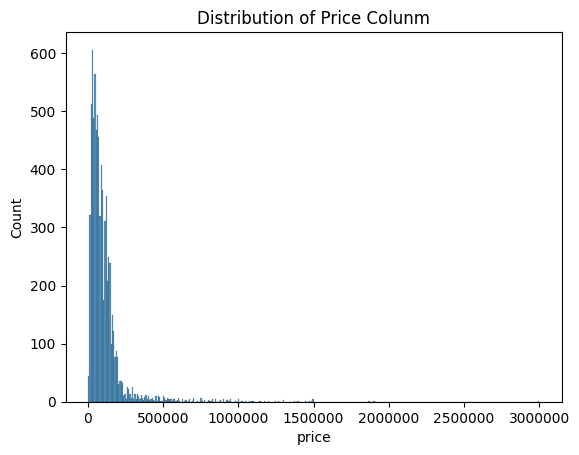

In [53]:
ax=sns.histplot(df['price'])
plt.title('Distribution of Price Colunm')
ax.xaxis.set_major_formatter('{x:.0f}')
plt.show()

- #### As according to the desciptive stats distribution is Right skewed
- #### Outliers in higher range of values

# Data Cleaning and Preprocessing

Cleaning model_name

In [54]:
df['model_name']

0          Bajaj Avenger Cruise 220 2017
1       Royal Enfield Classic 350cc 2016
2                    Hyosung GT250R 2012
3             Bajaj Dominar 400 ABS 2017
4                  Jawa Perak 330cc 2020
                      ...               
7852           Yamaha YZF-R15 150cc 2011
7853           Bajaj Discover 100cc 2015
7854             Bajaj Pulsar 180cc 2016
7855                Bajaj V15 150cc 2016
7856             Bajaj Pulsar 220cc 2016
Name: model_name, Length: 7765, dtype: object

- this columns contains year values at the end of every observation
- as we already have a seperate column for year we will slice the values

In [55]:
df['model_name']=df['model_name'].apply(lambda x:' '.join(x.split()[:3]))
df[['model_name']].head(5)

,model_name
0,Bajaj Avenger Cruise
1,Royal Enfield Classic
2,Hyosung GT250R 2012
3,Bajaj Dominar 400
4,Jawa Perak 330cc


Cleaning kms_driven

In [56]:
df[['kms_driven']].head(4)

,kms_driven
0,17000 Km
1,50000 Km
2,14795 Km
3,Mileage 28 Kms


In [57]:
# function for cleaning kms_driven column (Original Function)

def kms_driven_cleaner(value):
    value=value.split()[0:2]
    value=' '.join(value).replace(' ','')
    mod_value=0
    if(value):
        if 'Km' in value:
            mod_value= value.replace('Km','')
        if 'Mileage' in value and 'Km' in value:
            mod_value= value.replace('Mileage','')
            mod_value= value.replace('Km','')
        if 'Mileage' in value and  'pl' in value:
            mod_value=mod_value.replace('Mileage','')
            mod_value=mod_value.replace('pl','')
    
    if '-' in str(mod_value):
        mod_value=mod_value.str.replace('-','')
    if 'Yes' in str(mod_value):
        return 0
    return mod_value

In [58]:
# applying the function and converting the column data type to 'int64'

df['kms_driven']=df['kms_driven'].apply(kms_driven_cleaner)
df['kms_driven']=df['kms_driven'].astype(int)

# replacing 0's with mean 
df['kms_driven']=np.where(df['kms_driven']==0,df['kms_driven'].mean(),df['kms_driven'])

df['kms_driven']=df['kms_driven'].astype(int)
df[['kms_driven']].head(5)

,kms_driven
0,17000
1,50000
2,14795
3,17159
4,2000


In [59]:
df['owner'].unique()

array(['first owner', 'third owner', 'second owner',
       'fourth owner or more'], dtype=object)

owner and location columns are perfectly fine so we will deal with mileage column

Cleaning Mileage Column

In [60]:
df[['mileage']]

,mileage
0,\n\n 35 kmpl
1,\n\n 35 kmpl
2,\n\n 30 kmpl
3,\n\n 28 Kms
4,\n\n
...,...
7852,\n\n 42 kmpl
7853,\n\n 80 Kmpl
7854,\n\n 65 kmpl
7855,\n\n 57 kmpl


In [61]:
# defining function for cleaning mileage columns  ( original function )

def mileage_cleaner(val):
    val=val.replace('\n','').split()
    if(val!=[]):
        val=str(val[0])
        if 'Kmpl' in val:
            val=val.replace("Kmpl",'')
        if '-' in val:
            val=val.split('-')[0]
        if 'kmpl' in val:
            val=val.replace('kmpl','')
        if 'Liquid' in val:
            val=0
        return val
    
    else:
        return 0
    

In [62]:
# applying the function
df['mileage']=df['mileage'].apply(mileage_cleaner).astype('float64')

# replacing the 0's with mean
df['mileage']=np.where(df['mileage']==0,int(df['mileage'].mean()),df['mileage'])

df['mileage']=df['mileage'].astype('int64')
df[['mileage']].head(4)

,mileage
0,35
1,35
2,30
3,28


Cleaning power column

In [63]:
df['power'][:10]

0       19 bhp
1    19.80 bhp
2       28 bhp
3    34.50 bhp
4       30 bhp
5       25 bhp
6       17 bhp
7    20.21 bhp
8    42.90 bhp
9       13 bhp
Name: power, dtype: object

In [64]:
# Replacing BHP with ''
df['power']=df['power'].apply(lambda x:x.upper().replace('BHP','').strip())

# if HP is present then splitting by HP and getting the first value
df['power']=df['power'].apply(lambda x:x if x.find('HP')== -1 else x.split('HP')[0])

# replacing KW with '' and converting the unit FROM KW to HP as (1 KW == 1.34hp)
df['power']=df['power'].apply(lambda x:x if x.find('KW') == -1 else float(x.split()[0].replace('KW',''))*1.34)

# replacing PS WITH '' and converting the unit from PS to hp as (1ps = 0.98592hp)
df['power']=df['power'].apply(lambda x: x if str(x).find('PS')==-1 else float(x.split('PS')[0])**0.98592)

# dropping these two rows
df=df[~(df['power']=='16  AT 5000 RPM')]
df=df[~(df['power']=='100-110  (APPROX., NOT OFFICIALLY ANNOUNCED)')]

# rounding the power values to 2 decimal values
df['power']=df['power'].astype(float)
df['power']=round(df['power'],2)

In [65]:
df.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise,2017,17000,first owner,hyderabad,35,19.0,63500
1,Royal Enfield Classic,2016,50000,first owner,hyderabad,35,19.8,115000
2,Hyosung GT250R 2012,2012,14795,first owner,hyderabad,30,28.0,300000
3,Bajaj Dominar 400,2017,17159,first owner,pondicherry,28,34.5,100000
4,Jawa Perak 330cc,2020,2000,first owner,bangalore,40,30.0,197500


- now all the data is clean

# Exploratory Data Analysis

In [66]:
categorical_columns=df.select_dtypes('O').columns
numerical_colunms=df.select_dtypes(exclude='O').columns

for col in categorical_columns:
    print(f'{col} has {len(df[col].unique())} unique values')

model_name has 324 unique values
owner has 4 unique values
location has 558 unique values


- #### since there is ***high cardinality*** in ***model_name*** and ***location*** we will be considering only those values having count above 10

In [67]:
# filtering the dataframe for model_name
model_above_10_count=df['model_name'].value_counts()[df['model_name'].value_counts()>10].index.to_list()
df=df[df['model_name'].isin(model_above_10_count)]


# filtering the dataframe for location
location_above_10_count=df['location'].value_counts()[df['location'].value_counts()>10].index.tolist()
df=df[df['location'].isin(location_above_10_count)]

### Univarite Analysis ( model_name )

In [68]:
(df['model_name'].value_counts(normalize=True)*100)[:5]

Royal Enfield Classic        10.567352
Royal Enfield Thunderbird     6.685468
TVS Apache RTR                6.204380
Bajaj Pulsar 150cc            3.881885
Royal Enfield Bullet          3.798938
Name: model_name, dtype: float64

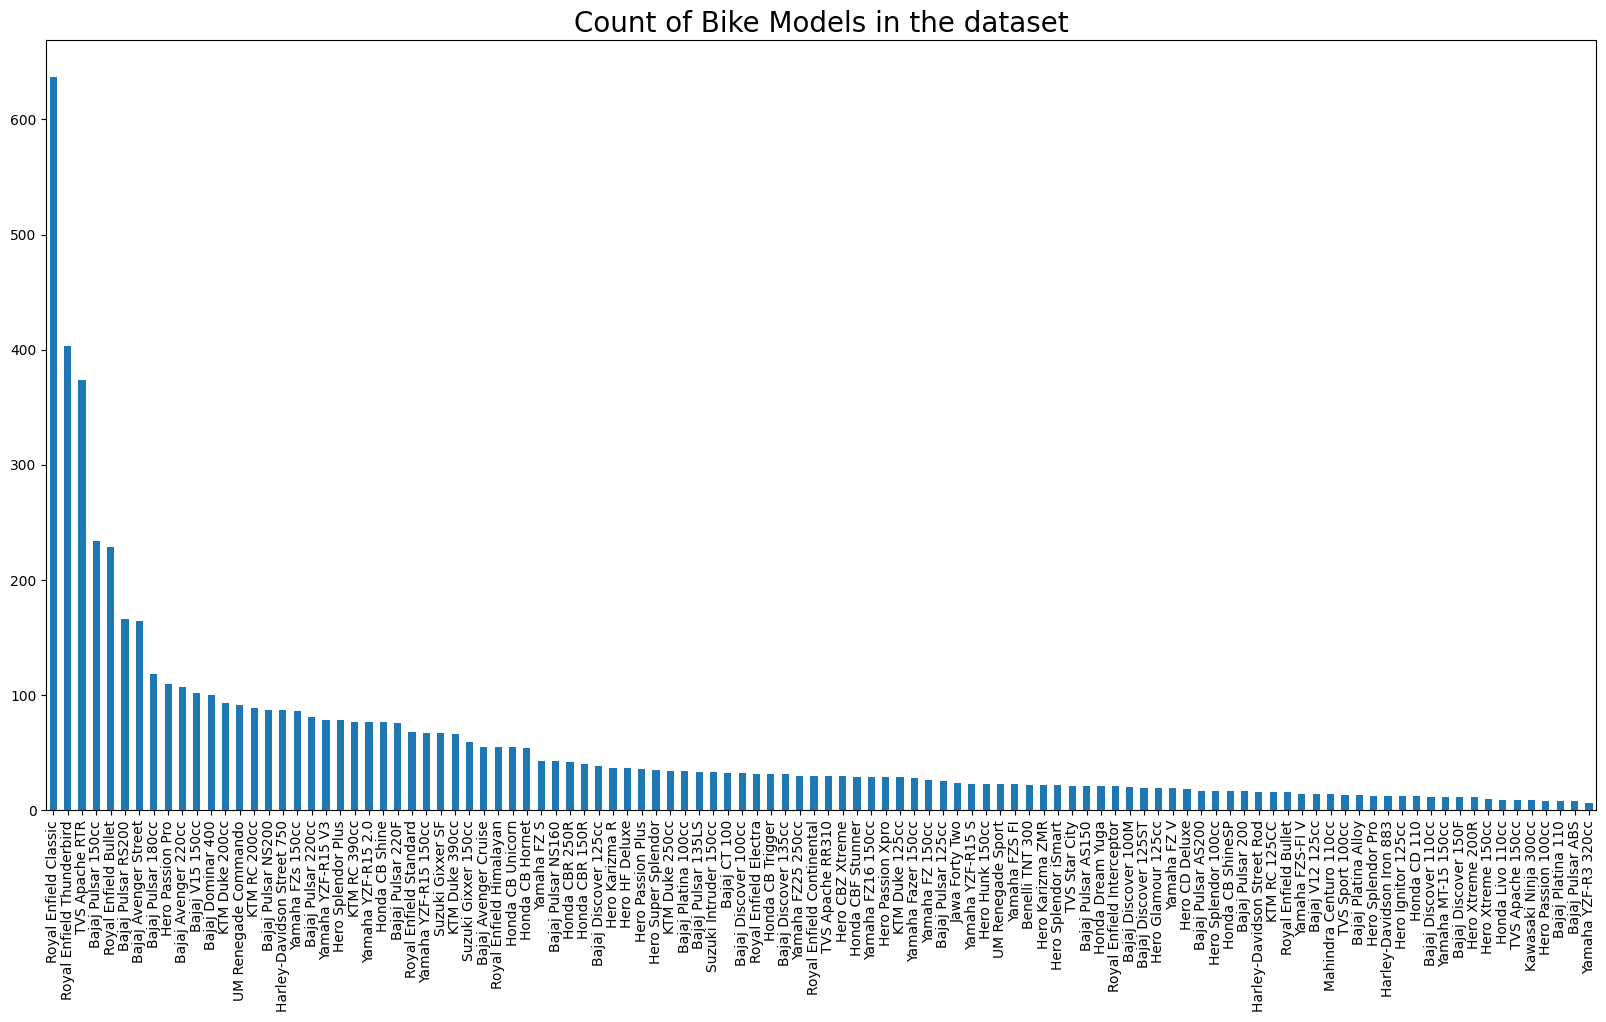

In [69]:
plt.figure(figsize=(20,10))
plt.title("Count of Bike Models in the dataset",fontdict={'size':20})
df['model_name'].value_counts().plot.bar()
plt.show()

- #### ***Royal enfield*** is the highest selling bike with the ***selling rate of 23.40%***
- #### then comes **Bajaj Pulsar** at **14.78%** selling rate
- #### ***TVS Apache*** is at **6.48%**
- #### ***Bajaj Avenger*** is at **5.21%**
- #### ***Yamaha YZF-R15*** at ***3.84%***

### Bivariate Analysis ( model_name ~ price )

In [70]:
df.groupby('model_name')['price'].mean().sort_values(ascending=False)[:5]

model_name
Harley-Davidson Iron 883      552968.583333
Harley-Davidson Street Rod    495142.187500
Harley-Davidson Street 750    387790.804598
Royal Enfield Interceptor     267005.809524
Yamaha YZF-R3 320cc           263458.333333
Name: price, dtype: float64

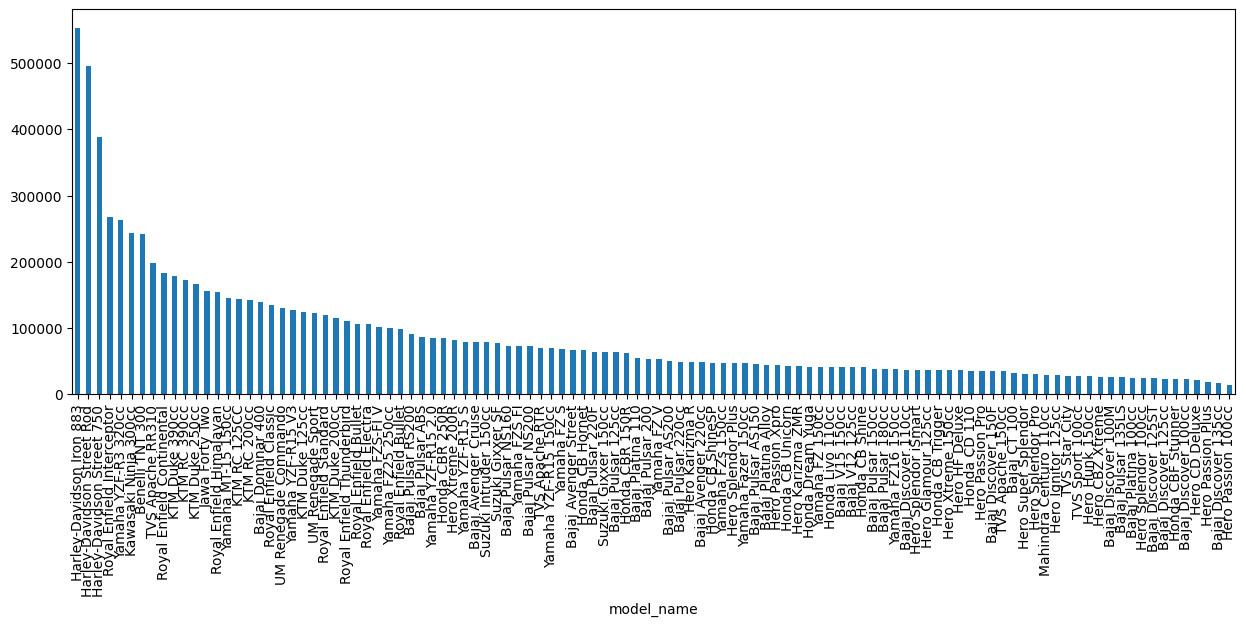

In [71]:
plt.figure(figsize=(15,5))
ax=df.groupby('model_name')['price'].mean().sort_values(ascending=False).plot.bar()
ax.yaxis.set_major_formatter('{x:.0f}')
plt.show()

- #### ***harley davidon fat*** is the most expensive bike in the dataset which average price goes up to 9.85 lakhs almost 1 Crore

- #### Top 5 most expensive bikes with their average prices 
    - Harley-Davidson Fat -----------    9.85 Lakhs
    - Triumph Street    -----------   6.96 lakhs
    - Harley-Davidson Iron -----------  5.52 Lakhs
    - Kawasaki Z650      -----------     5.13 Lakhs
    - Kawasaki Ninja    -----------      4.68 Lakhs

### Univariate Analysis ( model_year )

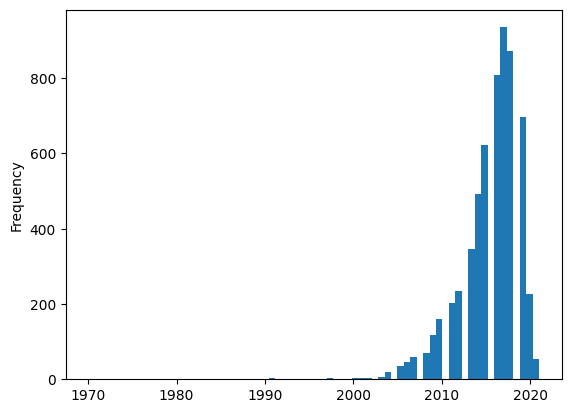

In [72]:
df['model_year'].plot.hist(bins=70)
plt.show()

- #### most of the bikes are manufactured between 2010 and 2020 

### Univariate Analysis ( kms_driven )

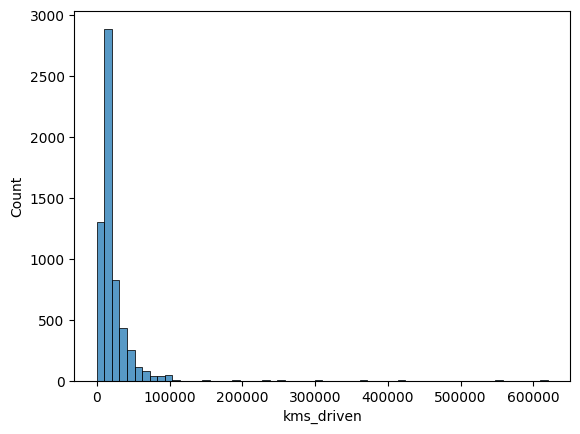

In [73]:
ax=sns.histplot(df['kms_driven'],bins=60)
ax.xaxis.set_major_formatter('{x:.0f}')
plt.show()

- #### Almost all of the bikes are driven under 2 lakh Kilometres
- #### distribution is clearly right skewed ( skewed towards lower values )


### Checking for Outliers in Kms_driven

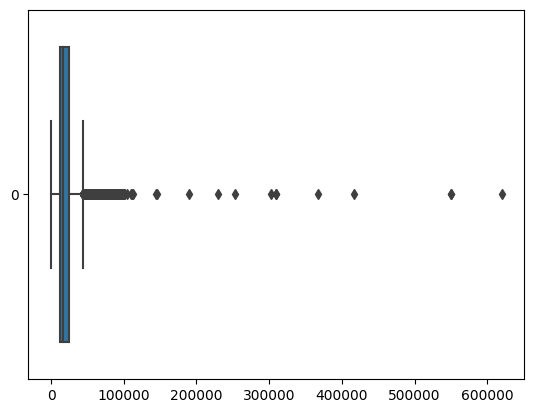

In [74]:
ax=sns.boxplot(df['kms_driven'],orient='h')
ax.xaxis.set_major_formatter('{x:.0f}')
plt.show()

- #### Outliers are present and need to be treated

### Bivariate Analysis (kms_driven ~ Price )

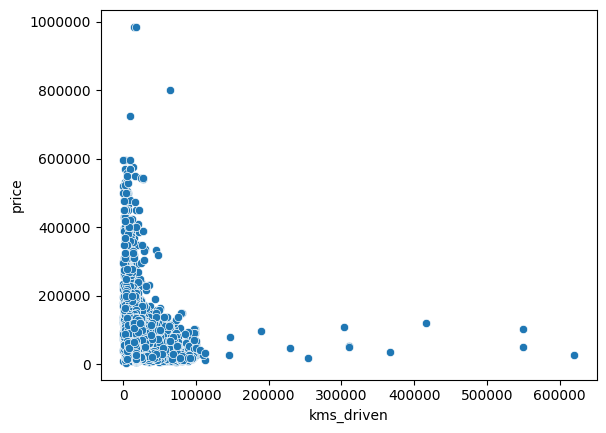

In [75]:
ax=sns.scatterplot(data=df,x='kms_driven',y='price')
ax.yaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_major_formatter('{x:.0f}')
plt.show()

- #### the density is clutered in the starting range
- #### but somehow it can be seen that if the bike is driven more it is likely to have a lesser price

### Univariate ( owner ) and Bivariate analysis ( owner ~ Price )

In [76]:
df['owner'].value_counts()/len(df)*100

first owner             87.259456
second owner             9.936961
third owner              1.708693
fourth owner or more     1.094891
Name: owner, dtype: float64

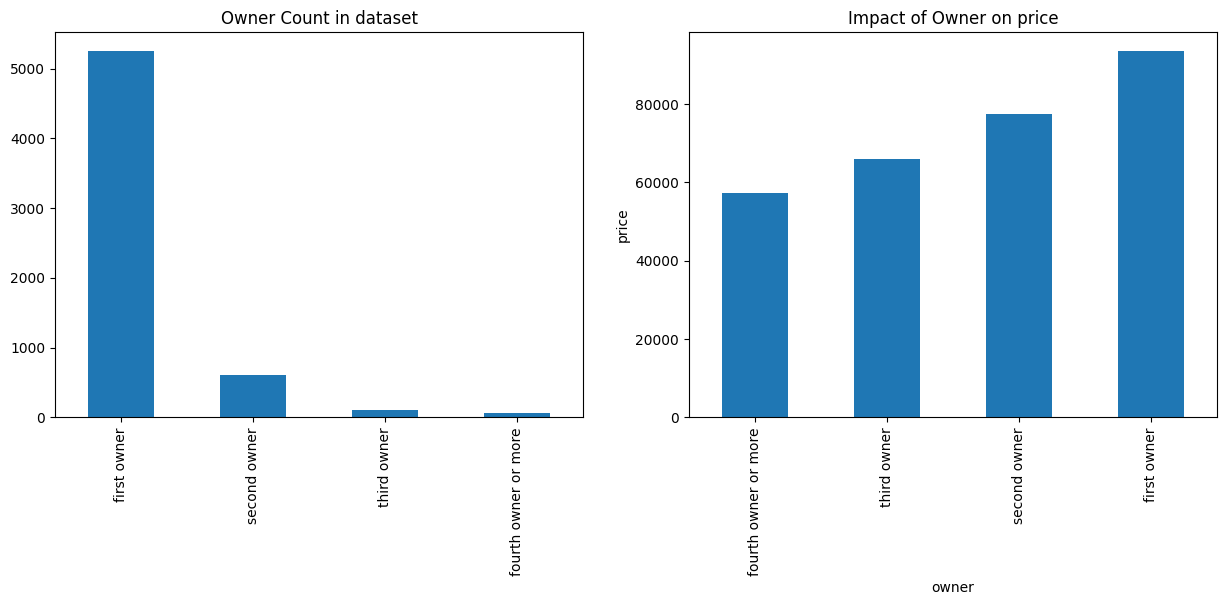

In [77]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Owner Count in dataset')
df['owner'].value_counts().plot.bar()

plt.subplot(1,2,2)
plt.title('Impact of Owner on price')
plt.ylabel("price")
df.groupby('owner')['price'].mean().sort_values().plot.bar()
plt.show()

- #### 87% of the bike are first owned that is they are bought from the showroom in the new condition
- #### price of the bike gets affected with second hand and third hand and gets more lower when a fourth owner buys it

### Univariate Analysis ( location )

In [78]:
(df['location'].value_counts()/len(df)*100)[:5]

delhi        21.715328
mumbai       12.541473
bangalore    11.712011
pune          5.192435
hyderabad     5.043132
Name: location, dtype: float64

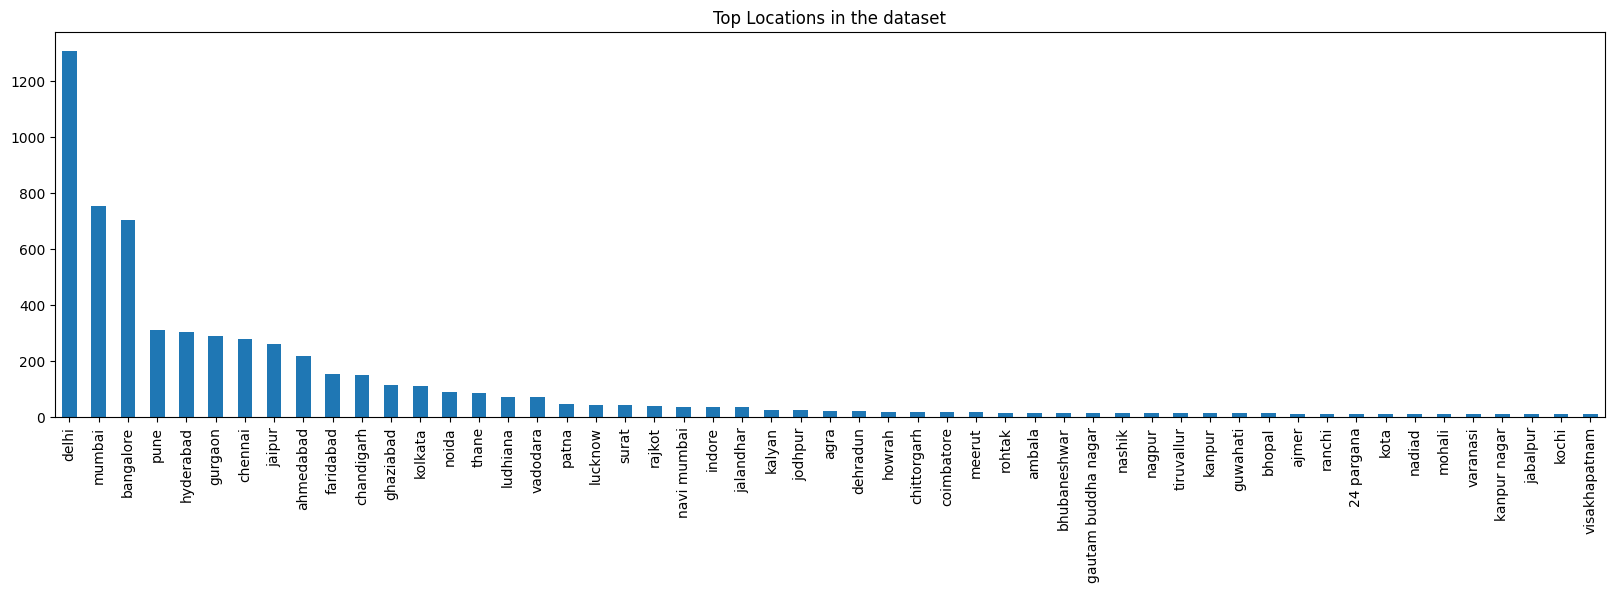

In [79]:
plt.figure(figsize=(20,5))
plt.title('Top Locations in the dataset')
df['location'].value_counts().plot.bar()
plt.show()

- #### Delhi is the main base of bike buisness ( sales )
- #### as delhi contributes 21.67% to the total sales
- #### mumbai contributes 12% and bangalore contributes 11% in the sales of bike

### Bivaritate Analysis ( Locations ~ Price )

In [80]:
df.groupby('location')['price'].mean().sort_values(ascending=False)[:5]

location
nagpur        159966.666667
jabalpur      154311.818182
jalandhar     128250.000000
chandigarh    127459.344371
mumbai        127049.531746
Name: price, dtype: float64

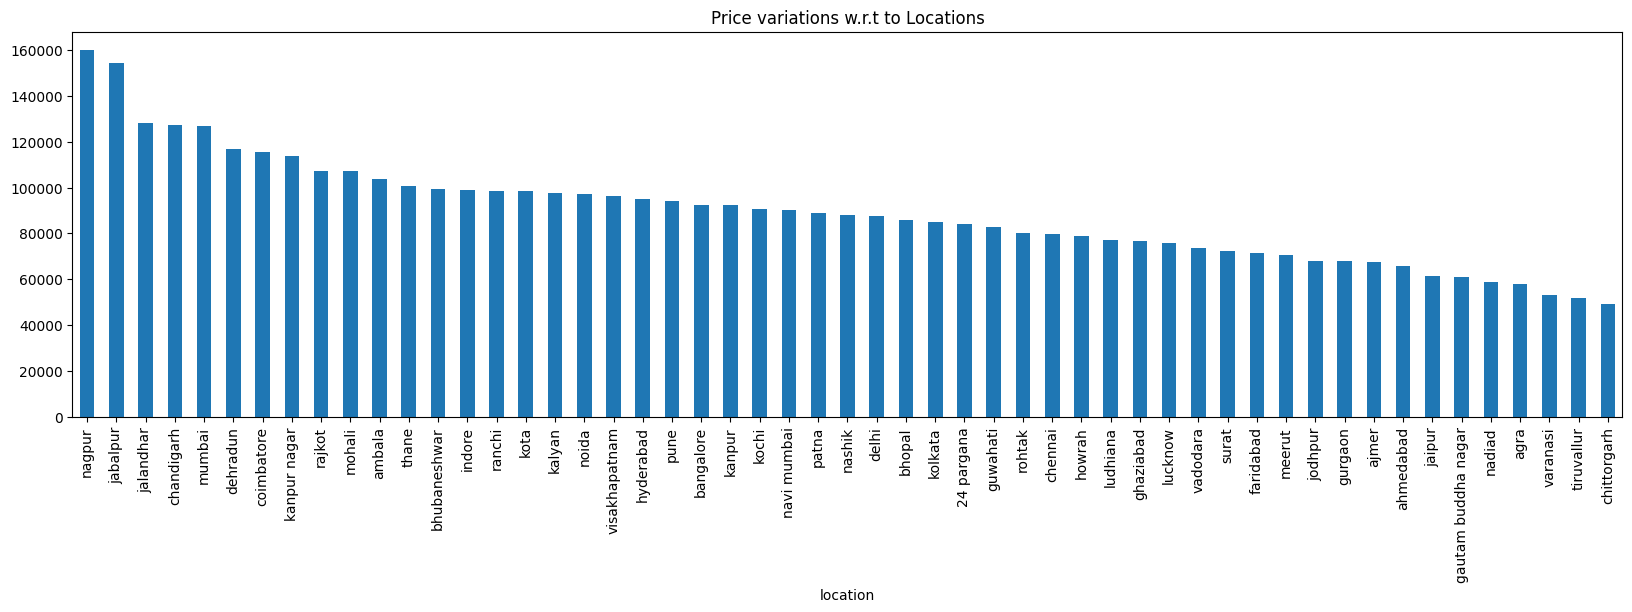

In [81]:
plt.figure(figsize=(20,5))
plt.title('Price variations w.r.t to Locations')
df.groupby('location')['price'].mean().sort_values(ascending=False).plot.bar()
plt.show()

- #### here we see a very nice curve
- #### Ranchi has the highest avg of bike price i.e 1.70Lakhs
- #### nagpur has 1.60 Lakhs
- #### jabalpur has 1.54 Lakhs
- #### jalandar has 1.48 Lakhs
- #### mumbai has 1.43 Lakhs

### Univariate Analysis ( Mileage )

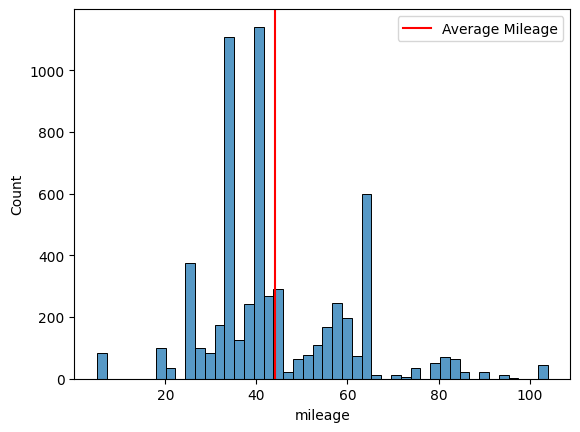

In [82]:
sns.histplot(df['mileage'])
plt.axvline(int(df['mileage'].mean()),color='red',label='Average Mileage')
plt.legend()
plt.show()

- #### Most of the bikes gives mileage of 44kmpl

### Bivariate Analysis ( mileage ~ price )

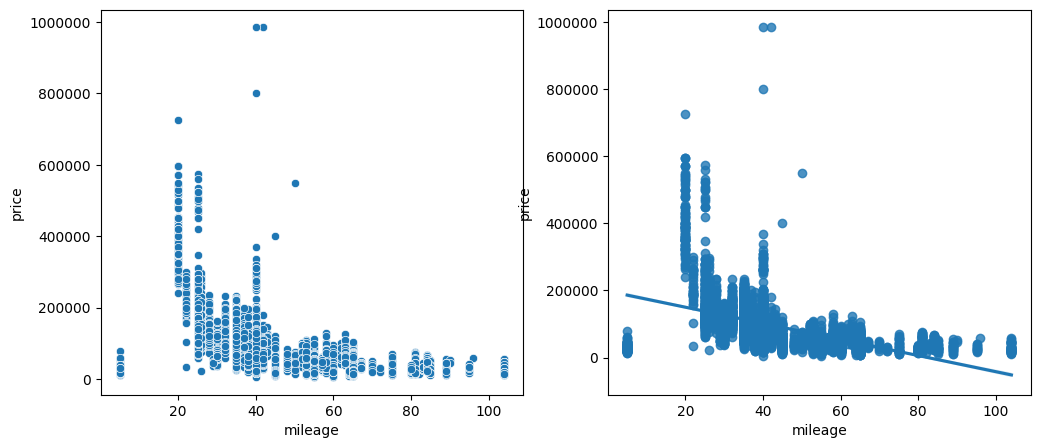

In [83]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ax=sns.scatterplot(data=df,x='mileage',y='price')
ax.yaxis.set_major_formatter('{x:.0f}')

plt.subplot(1,2,2)
ax=sns.regplot(data=df,x='mileage',y='price')
ax.yaxis.set_major_formatter('{x:.0f}')

- #### Price and mileage seems to have a negative linear relationship
- #### as the price of the bike increases the mileage of the bike decreases

### Univariate Analysis ( Power )

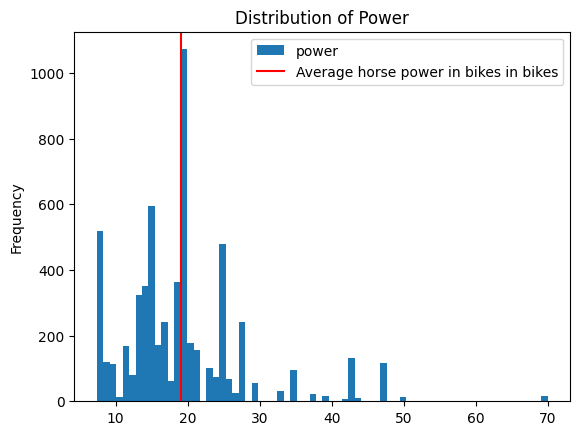

In [84]:
plt.figure(dpi=100)
df['power'].plot.hist(bins=70)
plt.axvline(int(df['power'].mean()),label='Average horse power in bikes in bikes',color='red')
plt.legend()
plt.title('Distribution of Power')
plt.show()

- #### Most of the bikes seems to have a power of 19bhp on an average

### Bivariate Analysis ( power ~ price )

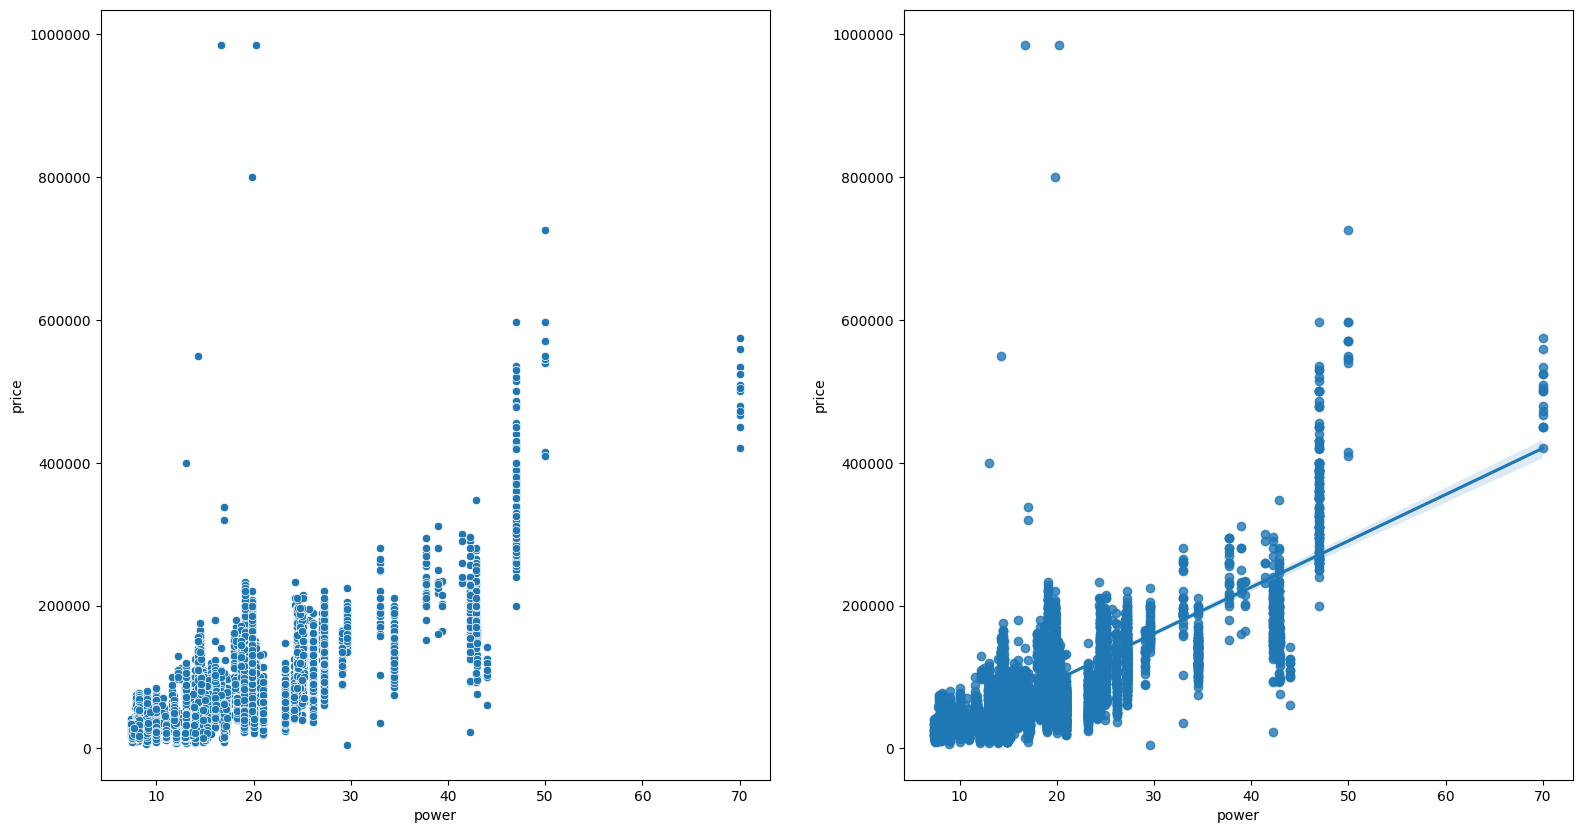

In [85]:
plt.figure(figsize=(19,10))
plt.subplot(1,2,1)
ax=sns.scatterplot(data=df,x='power',y='price')
ax.yaxis.set_major_formatter('{x:.0f}')


plt.subplot(1,2,2)
ax=sns.regplot(data=df,x='power',y='price')
ax.yaxis.set_major_formatter('{x:.0f}')

- #### power and price have strong linear relationship 
- #### as the power inreases the price also increases

### Multivariate Analysis ( mileage , power and price )

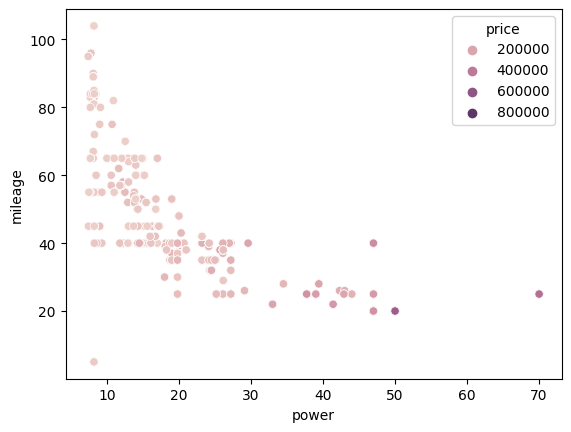

In [86]:
sns.scatterplot(data=df,x='power',y='mileage',hue='price')
plt.show()

- #### As the power of the engine increases the mileage of the bike seems to decrease

#### Checking for Outliers

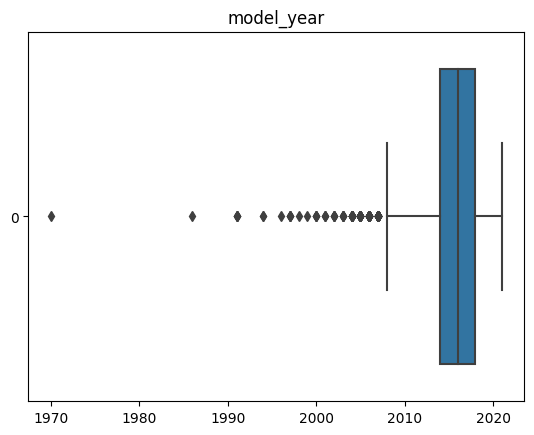

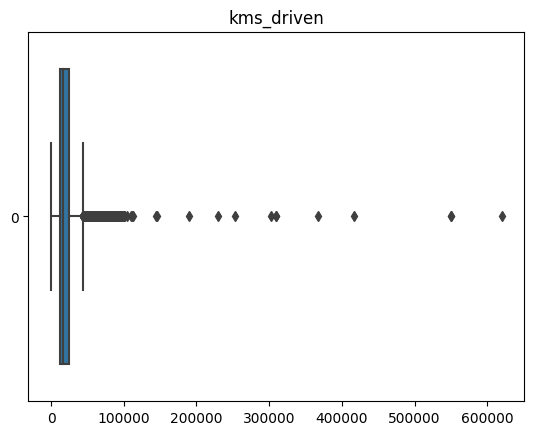

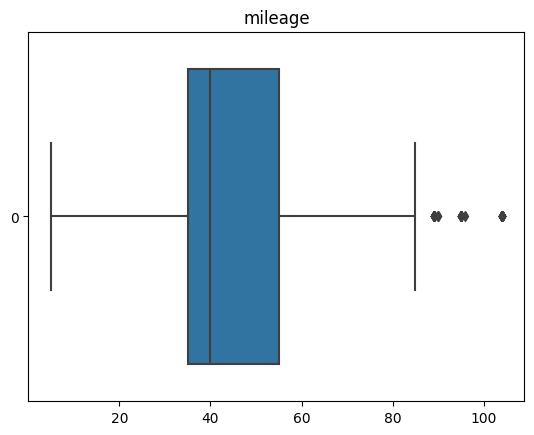

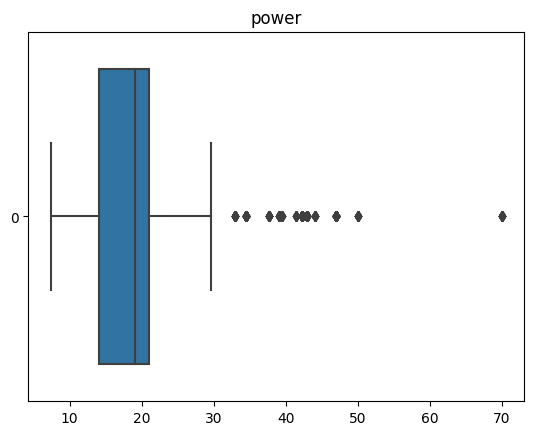

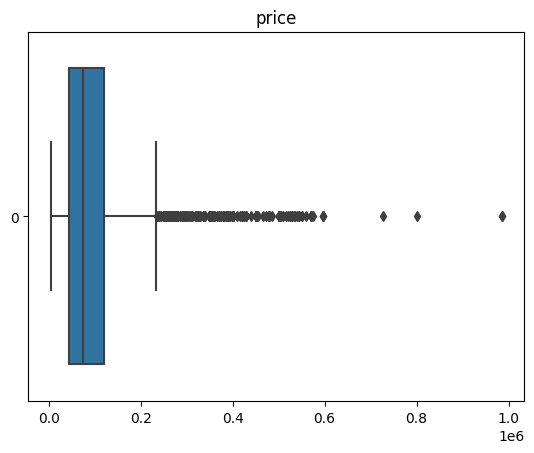

In [87]:
for col in numerical_colunms:
    plt.title(col)
    sns.boxplot(df[col],orient='h')
    plt.show()

- #### all the numerial variabels have outliers and need to be treated

# Feature Engineering

##### Splitting the data into target and independent variable

In [88]:
X=df.drop('price',axis=1)
y=df['price']

#### Checking Collinearity of features with target variable price

In [89]:
df.corr()['price']

model_year    0.374761
kms_driven   -0.231390
mileage      -0.522097
power         0.762959
price         1.000000
Name: price, dtype: float64

- #### as all the features are correlated , we will keep them all

### Checking for Multicollinearity

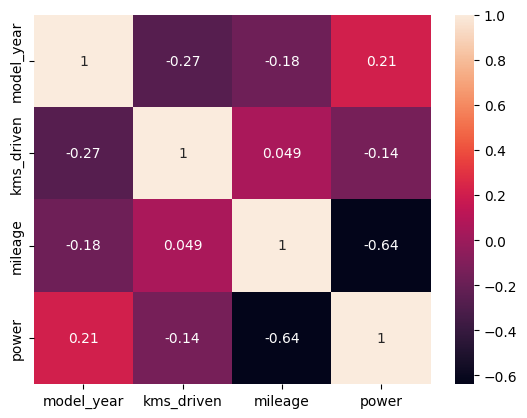

In [90]:
sns.heatmap(X.corr(),annot=True)
plt.show()

- #### No sign of Multicollinearity in independent variables

### Checking and Treating outliers in Price 

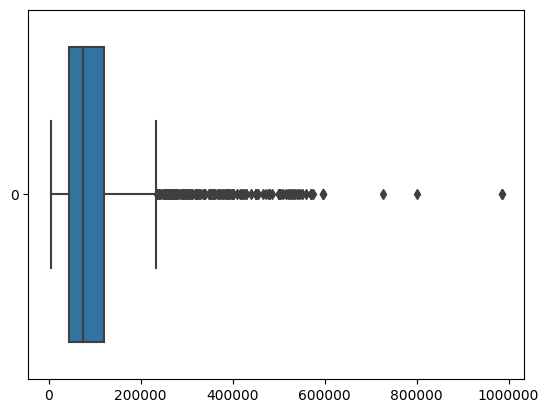

In [91]:
ax=sns.boxplot(df['price'],orient='h')
ax.xaxis.set_major_formatter('{x:.0f}')
plt.show()

In [92]:
# calculating the upper fence and lower fence

Q1=df['price'].quantile(.25)
Q3=df['price'].quantile(.75)
IQR=Q3-Q1

lower_fence=Q1-(1.5*IQR)
upper_fence=Q3+(1.3*IQR)

print(f'lower fence {lower_fence}\nupper fence {upper_fence}\n------------\nmin value {df["price"].min()}\nmax value {df["price"].max()}')

number_of_outliers=len(df[df['price']>upper_fence])
print(f"\nThere are a total of {number_of_outliers} outliers in price")

lower fence -70000.0
upper fence 218800.0
------------
min value 5000
max value 985625

There are a total of 229 outliers in price


- #### as lower fence is negative(-ve) we will consider the mininum value as lower fence and filter out the outliers using higher fence

### Removing outliers from price

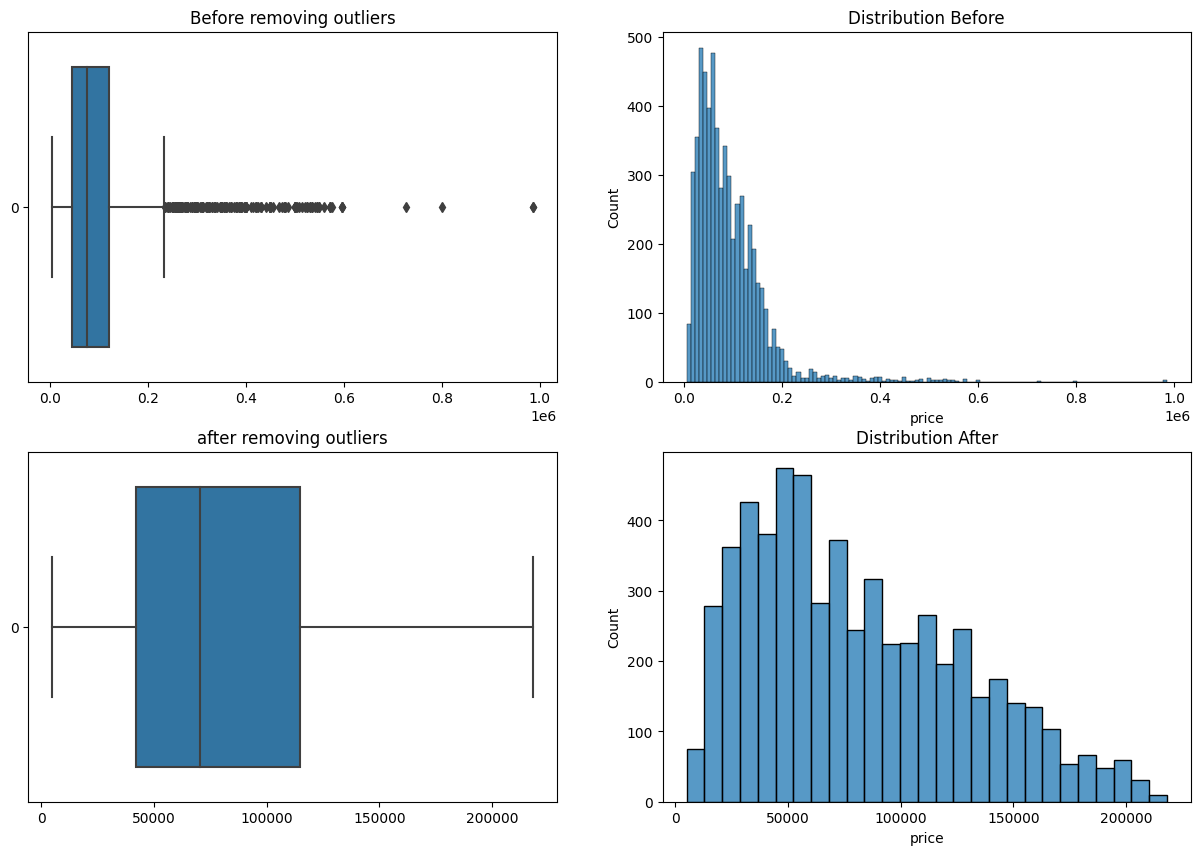

In [93]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Before removing outliers")
sns.boxplot(df['price'],orient='h')

plt.subplot(2,2,2)
plt.title("Distribution Before")
sns.histplot(df['price'])

df=df[df['price']<upper_fence]


plt.subplot(2,2,3)
plt.title("after removing outliers")
sns.boxplot(df['price'],orient='h')

plt.subplot(2,2,4)
plt.title("Distribution After")
sns.histplot(df['price'])

plt.show()

### Transforming the Distribution of Price ( target )
    - Sqaure Root Transformation

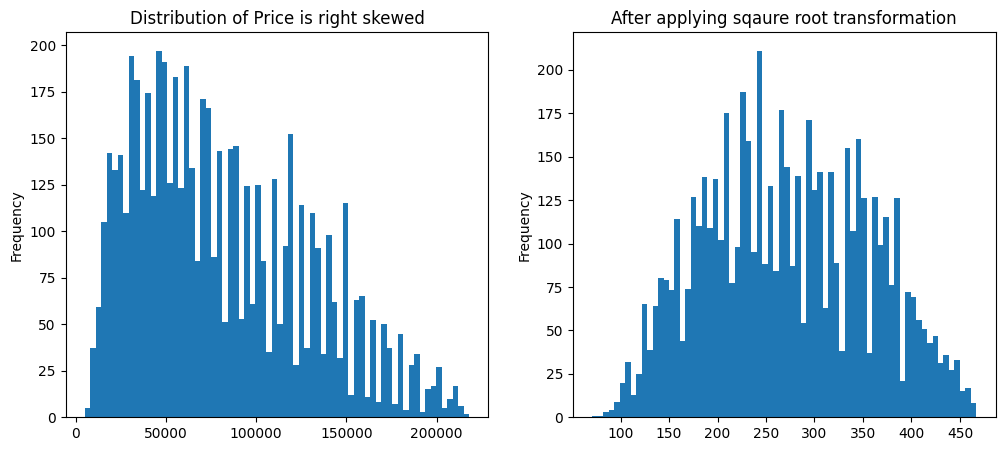

In [94]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Distribution of Price is right skewed")
df['price'].plot.hist(bins=70)

df['price_sqrt']=df['price']**(1/2)

plt.subplot(1,2,2)
plt.title("After applying sqaure root transformation")
df['price_sqrt'].plot.hist(bins=70)
plt.show()

# Modelling

In [95]:
# initializing y again
y=df['price_sqrt']

# dropping the transformed columns as it is already stored in y
df.drop('price_sqrt',axis=1,inplace=True)

X=df.drop('price',axis=1)

In [96]:
X

,model_name,model_year,kms_driven,owner,location,mileage,power
0,Bajaj Avenger Cruise,2017,17000,first owner,hyderabad,35,19.00
1,Royal Enfield Classic,2016,50000,first owner,hyderabad,35,19.80
5,KTM Duke 200cc,2012,24561,third owner,bangalore,35,25.00
6,Bajaj Pulsar 180cc,2016,19718,first owner,bangalore,65,17.00
7,TVS Apache RTR,2020,17159,first owner,hyderabad,40,20.21
...,...,...,...,...,...,...,...
7852,Yamaha YZF-R15 150cc,2011,7000,first owner,agra,42,16.00
7853,Bajaj Discover 100cc,2015,17159,first owner,delhi,80,7.70
7854,Bajaj Pulsar 180cc,2016,6407,first owner,bangalore,65,17.00
7855,Bajaj V15 150cc,2016,7524,first owner,bangalore,57,11.80


In [97]:
y

0       251.992063
1       339.116499
5       251.793566
6       234.520788
7       346.410162
           ...    
7852    234.520788
7853    167.332005
7854    248.475351
7855    221.359436
7856    254.950976
Name: price_sqrt, Length: 5799, dtype: float64

In [98]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=101,test_size=0.2)

### Making Column Transformers

In [99]:
encoder_transformer=ColumnTransformer([
    ('onehotencoding',OneHotEncoder(sparse=False,handle_unknown='ignore',drop='first'),[0,4]),
    ('ordinalencoder',OrdinalEncoder(categories=[['fourth owner or more','third owner','second owner','first owner']],handle_unknown='error'),[3]),
],remainder='passthrough')

scaler_transformer=ColumnTransformer([
    ('StandardScaler',MinMaxScaler(),[1,2,5,6]),
],remainder='passthrough')

### Making all the pipelines

In [100]:
pipeline_lr=Pipeline([('col_tnf',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                      ('linear',LinearRegression())
                      ])

pipeline_las=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('lasso',Lasso())
                     ])

pipeline_ridge=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('ridge',Ridge())
                     ])

pipeline_knn=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('knn',KNeighborsRegressor())
                     ])

pipeline_dt=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('dt',DecisionTreeRegressor())
                     ])

pipeline_svm=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('svm',SVR())
                     ])

pipeline_rf=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                      ('rf',RandomForestRegressor())
                      ])

pipeline_gbr=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('gbr',GradientBoostingRegressor())
                     ])

pipeline_abr=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('abr',AdaBoostRegressor())
                     ])

pipeline_etr=Pipeline([('encoder_transformer',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('etr',ExtraTreesRegressor())
                     ])

pipeline_xgb=Pipeline([('encoder_transformer0',encoder_transformer),
                        ('scaler_transformer',scaler_transformer),
                     ('xgb',XGBRegressor())
                     ])

# making a pipe_dict for mapping of values for model report
pipe_dict = {0: 'Linear Regression',1: 'Lasso Regression',2: 'Ridge Regression',3: 'KNN',
             4: 'Decision Tree', 5: 'SVM', 6: 'RandomForest' , 7: 'Gradient Boost',
             8: 'Ada Boost' , 9 : 'Extra Tree', 10: 'XGBoost'}

# making a pipelines list for iterative training of the models
pipelines=[pipeline_lr,pipeline_las,pipeline_ridge,pipeline_knn,pipeline_dt,pipeline_svm,pipeline_rf,pipeline_gbr,pipeline_abr,pipeline_etr,pipeline_xgb]

#### Training all the pipes here

In [101]:
for count,pipe in enumerate(pipelines):
    pipe.fit(X_train,y_train)
    print(f'{pipe_dict[count]} Trained Successfuly')

Linear Regression Trained Successfuly
Lasso Regression Trained Successfuly
Ridge Regression Trained Successfuly
KNN Trained Successfuly
Decision Tree Trained Successfuly
SVM Trained Successfuly
RandomForest Trained Successfuly
Gradient Boost Trained Successfuly
Ada Boost Trained Successfuly
Extra Tree Trained Successfuly
XGBoost Trained Successfuly


### Model Evaluation

In [102]:
model_report={}

for i,model in enumerate(pipelines):
    model_report[pipe_dict[i]]={'Training':model.score(X_train,y_train),'Testing':model.score(X_test,y_test)}

model_results=pd.DataFrame(model_report)
model_results

,Linear Regression,Lasso Regression,Ridge Regression,KNN,Decision Tree,SVM,RandomForest,Gradient Boost,Ada Boost,Extra Tree,XGBoost
Training,0.884681,0.762358,0.882670,0.715384,0.996307,0.172697,0.984934,0.909484,0.795088,0.996307,0.963775
Testing,0.861051,0.743803,0.858364,0.548237,0.852252,0.177275,0.902867,0.893367,0.784468,0.895872,0.908241


- ### XgBoost look like a more generalised model, so we will go with it

### Making predictions using Xgboost model

In [103]:
y_pred_test=pipeline_xgb.predict(X_test)

### Model Evaluation

In [104]:
mae=mean_absolute_error(y_test,y_pred_test)
r2=r2_score(y_test,y_pred_test)
adjusted_r2=1 - ((1 - r2_score(y_test, y_pred_test)) * (len(y_test) - 1) / (len(y_test) - len(X.columns) - 1))


print(f'R_sqaure : {r2}\nAdjusted R2 : {adjusted_r2}\nDifference Between r2 and adjusted r2 : {r2-adjusted_r2}\nMean Absolute Error : {mae}')



R_sqaure : 0.908240653805207
Adjusted R2 : 0.9076830883335373
Difference Between r2 and adjusted r2 : 0.0005575654716697409
Mean Absolute Error : 17.925921210245832


### Residual plot

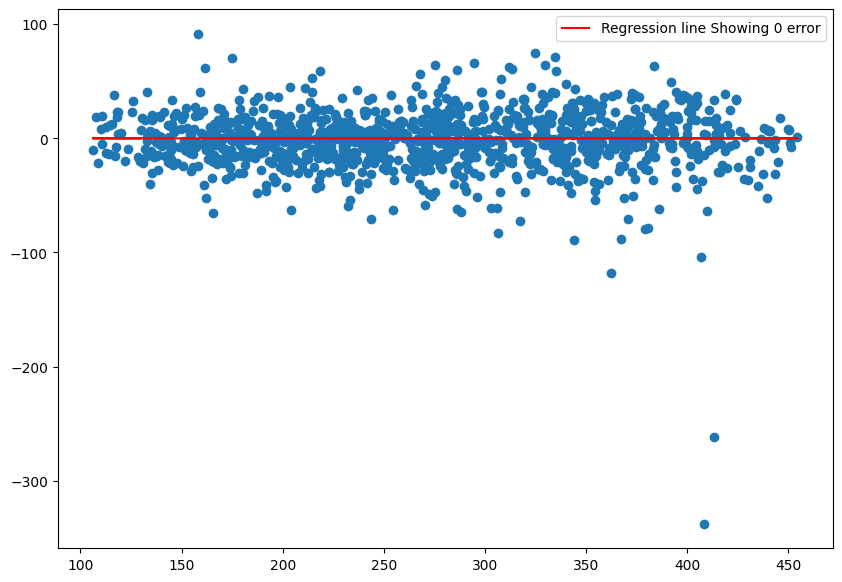

In [105]:
residuals=y_test-y_pred_test
plt.figure(figsize=(10,7))
plt.scatter(y_pred_test,residuals)
plt.plot(y_pred_test,[0 for i in range(len(y_test))],color='red',label='Regression line Showing 0 error')
plt.legend()
plt.show()

### Observations
- the residuals are densely populated between the limits -50 and 50..so there is a good probability that the residuals are normally distributed

- there is scope of improvement

- there are some outliers with positive magnitutde and negative magnitude

### Relationship between actual and predicted values

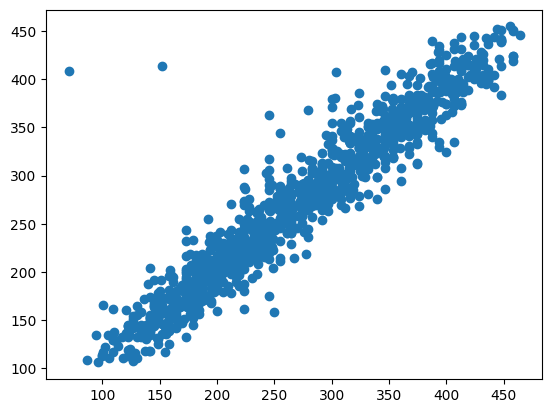

In [106]:
plt.scatter(y_test,y_pred_test)
plt.show()

- the actual and predicted values show a very strong linear relationship which is a good sign
- this means some useful values has been predicted by our model

### Distribution of Errors

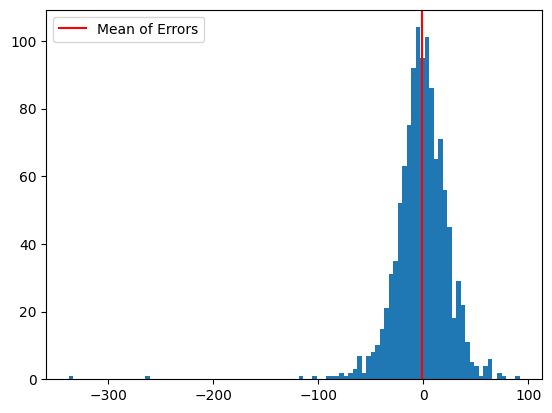

In [107]:
plt.hist(residuals,bins=100)
plt.axvline(residuals.mean(),color='red',label='Mean of Errors')
plt.legend()
plt.show()

- the distribution of errors follows a normal distribution and the mean of errors line is also exactly at zero

### Dumping the Xg Boost model pipeline and Dataframe

In [108]:
pickle.dump(pipeline_xgb,open('pipe.pkl','wb'))
pickle.dump(df,open('dataframe.pkl','wb'))